# Parte 2: Face Detection
### Santiago Juani & Florencia Migues

## Imports

In [1]:
%load_ext tensorboard

In [2]:
import cv2 
import numpy as np
from glob import glob
from enum import Enum
import os
import sklearn
from skimage.feature import hog
from sklearn import svm
import sklearn.neighbors
import matplotlib.pyplot as plt
from evaluation import precision_and_recall, interpolated_average_precision, evaluate_detector
import sys
from image_utils import non_max_suppression
from tqdm import tqdm
import pandas as pd
import pickle
from sklearn.model_selection import train_test_split
import datetime
import shutil

In [3]:
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard

## Feature Estractors
#### Implementacion: Hog

In [4]:
class FeatureExtractors(Enum):
    MiniImage = 1
    HOG = 2
    LBP = 3
    CNN = 4

def extract_features(method, image):
	'''Switch between Feature extraction Methods'''

	image_representation = []

	if method == FeatureExtractors.MiniImage:
		image_representation = extract_mini_image_features(image)
	elif method == FeatureExtractors.HOG:
		image_representation = extract_hog_features(image)
	elif method == FeatureExtractors.LBP:
		image_representation = extract_lbp_features(image)
	elif method == FeatureExtractors.CNN:
		image_representation = prep_for_cnn(image)
	
	return image_representation

def extract_mini_image_features(image,resize_size=(64,64)):
    shape = image.shape
    if len(shape) > 2:
        image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    resized_image = cv2.resize(image,resize_size)
    image_representation = resized_image.reshape(resize_size[0]*resize_size[1])
    return image_representation
  
def extract_lbp_features(img):
    return []

def extract_hog_features(img):
    fd = hog(img, orientations=8, pixels_per_cell=(16, 16),
             cells_per_block=(1, 1), visualize=False)
    return fd

def prep_for_cnn(img):
    if len(img.shape)==3 and img.shape[2] == 3:
        img = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    return img/255.0

## Data Loader & ShowImg

In [5]:
def load_training_data(training_positive_dir,trainign_negative_dir,feature_extractor=FeatureExtractors.CNN,target_size=[128,128]):
    ''' Function for loading loading training data from positive and negative examples
    '''
    positive_img_files = sorted(glob(training_positive_dir + '/*'))
    negative_img_files = sorted(glob(trainign_negative_dir + '/*'))
    #positive_img_files = positive_img_files[:5000]
    #negative_img_files = negative_img_files[:5000]
    training_data = []
    training_labels = []
    
    print('##Loading {} positive face images'.format(len(positive_img_files)))
    for img in tqdm(positive_img_files, total=len(positive_img_files)):
        image = cv2.imread(img)[...,::-1]
        image = cv2.resize(image, target_size, cv2.INTER_AREA)
        image_representation = extract_features(feature_extractor,image)
        training_data.append(image_representation)
        training_labels.append(1)
    
    print('##Loading {} negative face images'.format(len(negative_img_files)))
    for img in tqdm(negative_img_files,total=len(negative_img_files)):
        image = cv2.imread(img)[...,::-1]
        image = cv2.resize(image, target_size, cv2.INTER_AREA)
        image_representation = extract_features(feature_extractor,image)
        training_data.append(image_representation)
        training_labels.append(0)   
    
    training_data = np.asarray(training_data)
    training_labels = np.asarray(training_labels)
    return training_data, training_labels



def load_validation_data(validation_data_dir):

    validation_image_files = sorted(glob(validation_data_dir + '/*.jpg'))
    val_images = []
    
    validation_annotations= pd.read_pickle(os.path.join(validation_data_dir,'validation_bbox.pickle'))
    
    print(validation_annotations.shape)
    validation_bboxes = []
    for img_file in tqdm(validation_image_files,total=len(validation_image_files)):
        image = cv2.imread(img_file,cv2.IMREAD_COLOR)
        val_images.append(image)
        image_name = os.path.basename(img_file)
        bbox_info = validation_annotations.loc[validation_annotations["image_id"]==image_name]
        bbox = np.array([bbox_info['x_left'].values[0],bbox_info['y_top'].values[0],bbox_info['x_left'].values[0]+bbox_info['width'].values[0],bbox_info['y_top'].values[0]+bbox_info['height'].values[0]])
        validation_bboxes.append(bbox)
        
    return val_images, validation_bboxes



def show_image_with_bbox(image,bboxes,gt_bbox,draw_GT=True):
    if draw_GT: 
        cv2.rectangle(image, (gt_bbox[0],gt_bbox[1]), (gt_bbox[2],gt_bbox[3]), (0, 0, 255), 2)

    for bbox in bboxes:
        if len(bbox) == 4:   
            top_left = (int(bbox[0]),int(bbox[1]))
            bottom_right = (int(bbox[0])+ int(bbox[2]),int(bbox[1])+int(bbox[3]))
            cv2.rectangle(image, top_left, bottom_right, (255, 0, 0), 2)

    plt.imshow(image[...,::-1])
    plt.axis('off')
    plt.show()

## Sliding Window
Implementacion propia

In [6]:
def total_windows(img, window_size, step_size):
    [i_rows, i_cols] = img.shape;
    w_rows = window_size[1];
    w_cols = window_size[0];
    
    cc = (i_cols + step_size - w_cols)/step_size
    cr = (i_rows + step_size - w_rows)/step_size
    return int(cc*cr)

def sliding_window(img, window_size, scale, step_size):
    
    scales = [3*(scale/4), 2*(scale/3)]
    images = []
    
    ct = 0
    
    for s in scales:
        width = int(img.shape[1]*s)
        heigh = int(img.shape[0]*s)
        
        image = cv2.resize(img, (width, heigh),
                           interpolation = cv2.INTER_AREA)
        
        if (image.shape[0] < window_size[0] or image.shape[1] < window_size[1]):
            break
        
        images.append(image)
        ct += total_windows(image, window_size, step_size)
       
    patches = np.zeros((window_size[0], window_size[1], ct))
    bbox_locations = np.zeros((ct, 4))

    i=0
    err = 0
    for image in images:
        for y in range(0, image.shape[0], step_size):
            for x in range(0, image.shape[1], step_size):
                try:
                    patches[:,:,i] = image[y:y+window_size[0], x:x+window_size[1]]
                    bbox_locations[i,:] = [int(x*(float(img.shape[1])/float(image.shape[1]))), 
                                           int(y*(float(img.shape[0])/float(image.shape[0]))),
                                           int(window_size[0]*(float(img.shape[0])/float(image.shape[0]))),
                                           int(window_size[1]*(float(img.shape[1])/float(image.shape[1])))]
                    i+= 1
                except:
                    if i >= ct:
                        err += 1
    #print('i: ', i, 't: ', ct, 'err: ', err)
    return patches, bbox_locations

 53%|█████▎    | 93/175 [00:00<00:00, 464.49it/s]

(175, 5)


100%|██████████| 175/175 [00:00<00:00, 463.77it/s]


i:  226 t:  253 err:  0


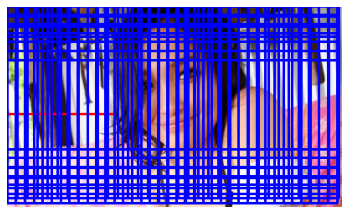

In [33]:
data_dir='./'
face_detection_dir = os.path.join(data_dir, 'face_detection')
validation_raw_faces_dir = os.path.join(face_detection_dir,'val_raw_images')

val_data, val_bboxes = load_validation_data(validation_faces_dir)

image = val_data[30]
gray_image = extract_features(FeatureExtractors.CNN, image)

window_size = (128, 128)
stride = 8

patches, bbox_locations = [], []
patches, bbox_locations = sliding_window(gray_image, window_size, 1, stride)
show_image_with_bbox(image, bbox_locations,
                     [0, 0, window_size[0], window_size[1]],
                     draw_GT=True)

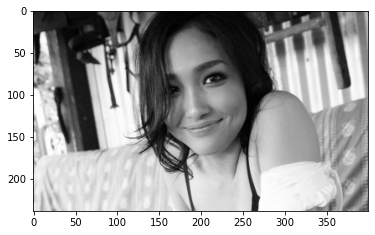

In [34]:
plt.imshow(gray_image, cmap='gray')

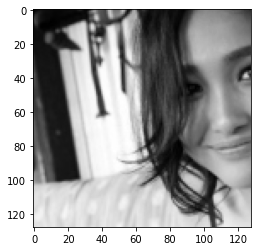

In [37]:
plt.imshow(patches[:,:,70], cmap='gray')

# Entrenamiento del Modelo

## Carga de datos de entrenamiento

#### Ubicacion de los datos

In [7]:
data_dir='./'
face_detection_dir = os.path.join(data_dir, 'face_detection')
training_faces_dir = os.path.join(face_detection_dir,'cropped_faces')
negative_examples_training_dir = os.path.join(face_detection_dir,'negative_data')
validation_faces_dir = os.path.join(face_detection_dir,'testing')
validation_raw_faces_dir = os.path.join(face_detection_dir,'val_raw_images')

#### Load Training Data

In [8]:
training_data, training_labels = load_training_data(training_faces_dir,
                                                   negative_examples_training_dir,
                                                   FeatureExtractors.CNN)

  1%|          | 58/9914 [00:00<00:19, 502.12it/s]

##Loading 9914 positive face images


  1%|          | 55/7489 [00:00<00:13, 540.21it/s]

##Loading 7489 negative face images


100%|██████████| 7489/7489 [00:13<00:00, 572.74it/s]


#### Load Validation Data

In [8]:
validation_data = load_validation_data(validation_faces_dir)

  1%|          | 1/175 [00:00<00:20,  8.54it/s]

(175, 5)


100%|██████████| 175/175 [00:00<00:00, 301.98it/s]


## Keras CNN

In [32]:
model = Sequential()


model.add(Conv2D(32, (3,3), input_shape=(128, 128, 1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(32, (3,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(32, (3,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))

model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
             optimizer='rmsprop',
             metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      320       
                                                                 
 batch_normalization (BatchN  (None, 126, 126, 32)     128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 126, 126, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 61, 61, 32)       1

## Model Training

In [ ]:
%tensorboard --logdir ./logs/ --host localhost

In [ ]:
if not os.path.exists('./checkpoints'):
    os.makedirs('./checkpoints')
check_point_model = os.path.join('./checkpoints','checkpoint_model_more_LR.hdf5')

In [30]:
x_train, x_test, y_train, y_test = train_test_split(training_data,
                                                    training_labels,
                                                    test_size=0.33,
                                                    random_state=7)

In [ ]:
if os.path.exists('./logs'):
    shutil.rmtree('./logs')
checkpoint = ModelCheckpoint(check_point_model,
                            monitor='val_loss',
                            verbose=1,
                            save_best_only=True,
                            mode='min')

history = model.fit(x_train, y_train,
                    epochs=200,
                    batch_size=32,
                    validation_data=(x_test, y_test),
                    callbacks=[checkpoint, TensorBoard(f'./logs/model_more_LR')])

In [34]:
model.load_weights(os.path.join('./checkpoints','checkpoint_model.hdf5'))

test_loss, test_acc = classifier.evaluate(x_test,  y_test, verbose=2)
print('test_acc', test_acc)
print('test_loss', test_loss)

180/180 - 19s - loss: 0.0421 - accuracy: 0.9906 - 19s/epoch - 103ms/step
test_acc 0.9905972480773926
test_loss 0.04212552681565285


#### Save trained model

In [ ]:
#svm
pickle.dump(svm_classifier, open('./face_detector', 'wb'))

In [14]:
#cnn
model.save('face_detector.h5')

#### Load trained model

In [ ]:
# svm
classifier = pickle.load(open('./face_detector','rb'))

In [33]:
#cnn
classifier = keras.models.load_model('face_detector.h5')

In [ ]:
## RELOAD MODEL
model = keras.models.load_model('face_detector.h5')
model.summary()

In [36]:
tp = 0
fp = 0
tn = 0
fn = 0

for i in range(len(x_test)):
    score = classifier.predict([np.asarray(x_test[i])])
    if score >= 0.3:
        if y_test[i] > 0.5:
            tp += 1
        else:
            fp += 1
    else:
        if y_test[i] < 0.5:
            tn += 1
        else:
            fn += 1
        
print('tp', tp)
print('tn', tn)
print('fp', fp)
print('fn', fn)

ValueError: in user code:

    File "C:\Users\santi\anaconda3\lib\site-packages\keras\engine\training.py", line 1845, in predict_function  *
        return step_function(self, iterator)
    File "C:\Users\santi\anaconda3\lib\site-packages\keras\engine\training.py", line 1834, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\santi\anaconda3\lib\site-packages\keras\engine\training.py", line 1823, in run_step  **
        outputs = model.predict_step(data)
    File "C:\Users\santi\anaconda3\lib\site-packages\keras\engine\training.py", line 1791, in predict_step
        return self(x, training=False)
    File "C:\Users\santi\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\santi\anaconda3\lib\site-packages\keras\engine\input_spec.py", line 228, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" '

    ValueError: Exception encountered when calling layer "sequential" (type Sequential).
    
    Input 0 of layer "conv2d" is incompatible with the layer: expected min_ndim=4, found ndim=2. Full shape received: (32, 128)
    
    Call arguments received by layer "sequential" (type Sequential):
      • inputs=('tf.Tensor(shape=(32, 128), dtype=float32)',)
      • training=False
      • mask=None


## Sliding Window & Results

 17%|█▋        | 29/175 [00:00<00:00, 281.63it/s]

(175, 5)


100%|██████████| 175/175 [00:00<00:00, 340.82it/s]


i:  524 t:  526 err:  0
17/17 [==============================] - 2s 96ms/step
sbb 1 sc [1.]


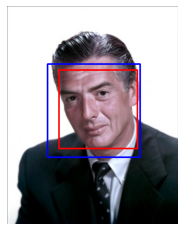

i:  386 t:  428 err:  0
14/14 [==============================] - 1s 99ms/step
sbb 1 sc [0.9999997]


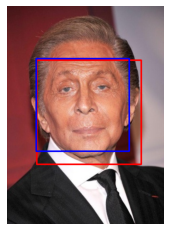

i:  426 t:  446 err:  0
14/14 [==============================] - 1s 97ms/step
sbb 1 sc [0.9999998]


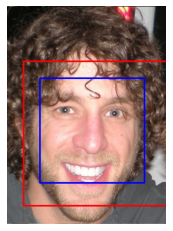

i:  586 t:  608 err:  0
19/19 [==============================] - 2s 108ms/step
sbb 2 sc [1.         0.88437814]


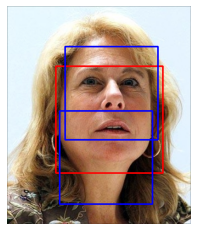

i:  306 t:  330 err:  0
11/11 [==============================] - 1s 100ms/step
sbb 1 sc [1.]


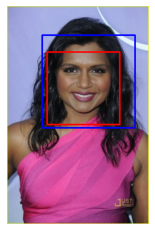

i:  386 t:  403 err:  0
13/13 [==============================] - 1s 106ms/step
sbb 1 sc [0.99999964]


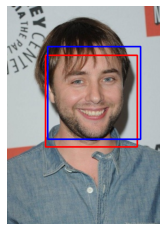

i:  477 t:  477 err:  441
15/15 [==============================] - 2s 114ms/step
sbb 1 sc [1.]


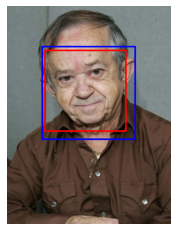

i:  346 t:  357 err:  0
12/12 [==============================] - 1s 104ms/step
sbb 1 sc [1.]


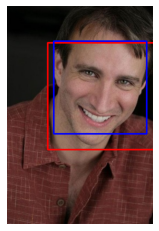

i:  586 t:  620 err:  0
20/20 [==============================] - 2s 102ms/step
sbb 2 sc [1.        0.9935099]


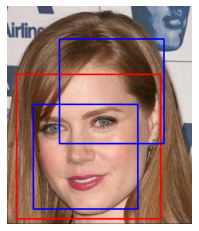

i:  342 t:  352 err:  0
11/11 [==============================] - 1s 99ms/step
sbb 2 sc [1.        0.8395763]


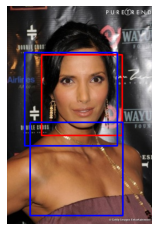

i:  426 t:  466 err:  0
15/15 [==============================] - 2s 99ms/step
sbb 1 sc [0.8381064]


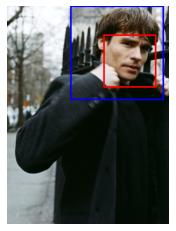

i:  129 t:  141 err:  0
5/5 [==============================] - 0s 84ms/step
sbb 1 sc [0.9999995]


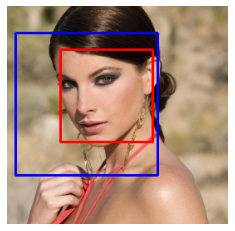

i:  342 t:  352 err:  0
11/11 [==============================] - 1s 117ms/step
sbb 1 sc [1.]


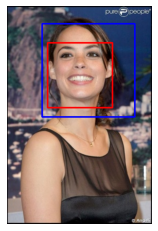

i:  386 t:  403 err:  0
13/13 [==============================] - 1s 112ms/step
sbb 2 sc [1.         0.99500805]


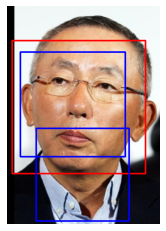

i:  217 t:  231 err:  0
8/8 [==============================] - 1s 108ms/step
sbb 1 sc [1.]


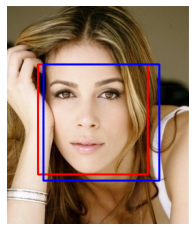

In [42]:
'''
Afinar parametros:
    threshold_p
    overlap_threshold
    non_max_threshold
'''

non_max_threshold = 0.8
window_size = (128, 128)
scale = 1
predictions = []
threshold_p = 0.5
overlap_threshold = 0.5
validation_data, validation_bboxes = load_validation_data(validation_faces_dir)
sample_images = 15
stride = 8
for img, gt_bbox in zip(validation_data[:sample_images],validation_bboxes[:sample_images]):
    gray_image = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    patches, bbox_locations = sliding_window(gray_image,window_size,scale,stride)
    
    ## You need to extract features for every patch (same features you used for training the classifier)
    patches_feature_representation = []
    for i in range(patches.shape[2]):
        patch_representation = extract_features(FeatureExtractors.CNN, patches[:,:,i])
        patches_feature_representation.append(patch_representation)
    patches_feature_representation = np.asarray(patches_feature_representation)
    
    ## Get prediction label for each sliding window patch
    if patches_feature_representation.shape[0] > 0:
        scores = classifier.predict(patches_feature_representation)
        face_probabilities = scores[:,0]
        face_bboxes = bbox_locations[face_probabilities>threshold_p]
        face_bboxes_probabilites = face_probabilities[face_probabilities>threshold_p]
        
        # Do non max suppression and select strongest probability box
        [selected_bbox, selected_score] = non_max_suppression(face_bboxes,face_bboxes_probabilites,0.3)
        
        print('sbb', len(selected_bbox), 'sc', selected_score)
    else:
        selected_bbox = []
    show_image_with_bbox(img, selected_bbox, gt_bbox)

## Evaluate Detector

In [38]:
total_true_positives = []
total_real_positives = []
total_positive_predictions = []
window_size = [128, 128]
validation_data, validation_bboxes = load_validation_data(validation_faces_dir)
k = 0
stride = 8
scale = 1

for img, gt_bbox in zip(validation_data,validation_bboxes):
    gray_image = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    patches, bbox_locations = sliding_window(gray_image,window_size,scale,stride)
    
    ## You need to extract features for every patch (same features you used for training the classifier)
    patches_feature_representation = []
    for i in range(patches.shape[2]):
        patch_representation = extract_features(FeatureExtractors.CNN, patches[:,:,i])
        patches_feature_representation.append(patch_representation)
    patches_feature_representation = np.asarray(patches_feature_representation)
    
    ## Get score for each sliding window patch
    scores = classifier.predict(patches_feature_representation)  

    ## Positive Face Probabilities
    face_probabilities = scores[:,0]

    [ detected_true_positives, image_real_positives, detected_faces ] = evaluate_detector( bbox_locations, face_probabilities, gt_bbox)
    total_true_positives.append(detected_true_positives)
    total_real_positives.append(image_real_positives)
    total_positive_predictions.append(detected_faces)
        
total_true_positives = np.asarray(total_true_positives)
total_real_positives = np.asarray(total_real_positives)
total_positive_predictions = np.asarray(total_positive_predictions)

  0%|          | 0/175 [00:00<?, ?it/s]

(175, 5)


100%|██████████| 175/175 [00:00<00:00, 318.90it/s]


i:  524 t:  526 err:  0
17/17 [==============================] - 2s 101ms/step
i:  386 t:  428 err:  0
14/14 [==============================] - 1s 101ms/step
i:  426 t:  446 err:  0
14/14 [==============================] - 2s 108ms/step
i:  586 t:  608 err:  0
19/19 [==============================] - 2s 122ms/step
i:  306 t:  330 err:  0
11/11 [==============================] - 1s 113ms/step
i:  386 t:  403 err:  0
13/13 [==============================] - 1s 109ms/step
i:  477 t:  477 err:  441
15/15 [==============================] - 2s 114ms/step
i:  346 t:  357 err:  0
12/12 [==============================] - 1s 107ms/step
i:  586 t:  620 err:  0
20/20 [==============================] - 2s 102ms/step
i:  342 t:  352 err:  0
11/11 [==============================] - 1s 112ms/step
i:  426 t:  466 err:  0
15/15 [==============================] - 2s 109ms/step
i:  129 t:  141 err:  0
5/5 [==============================] - 1s 97ms/step
i:  342 t:  352 err:  0
11/11 [======================

In [39]:
precision, recall = precision_and_recall(total_true_positives, total_real_positives,total_positive_predictions)

(0.0, 1.1)

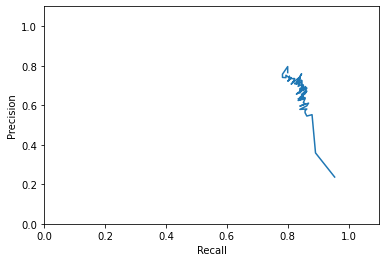

In [40]:
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.xlim(0,1.1)
plt.ylim(0,1.1)

In [41]:
ap = interpolated_average_precision(recall,precision)
print('Detection Average Precision is {}'.format(ap))

Detection Average Precision is [0.63636364]


# Implementacion CNN:
### 0.58717469 (Validacion inicial)
### 0.63636364 (Testing final)